In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!mkdir pfam
!cp drive/MyDrive/archive.zip pfam

In [ ]:
!unzip pfam/archive.zip -d pfam/

In [ ]:
import glob
import pandas as pd

def read_files(dir):
    """
    -Description:
    
    Read all files from directory matching substring

    @param str dir: directory where the files are stored

    @out DataFrame: pandas dataframe containing all
    """
    files = glob.glob(dir+"/*")
    dfs = []
    for file in files:
        df = pd.read_csv(file , index_col = None)
        dfs.append(df)
    return pd.concat(dfs)

In [ ]:
#Read training , dev and test data separately:

train = read_files("pfam/random_split/train")
dev = read_files("pfam/random_split/dev")
test = read_files("pfam/random_split/test")

In [ ]:
!pip install pycodestyle pycodestyle_magic
!pip install flake8

Pycodestyle can be used as an alternative to **pylint** for ensuring the use of a correct coding standard.

In [ ]:
%load_ext pycodestyle_magic



---


# Dataset Analysis

Before getting started with the modelling, I will perform exploratory data analysis to get a deeper understanding of the data and find potential caveats in the data. 

As the number of classes is very high, it is important to check that they are contained on the validation and test set.

In [ ]:
print("Unique classes on train set: " , len(train["family_accession"].unique()) )
print("Unique classes on dev set: " , len(dev["family_accession"].unique()))
print("Unique classes on test set: " , len(test["family_accession"].unique()))

Unique classes on train set:  17929
Unique classes on dev set:  13071
Unique classes on test set:  13071


In [ ]:
unique_dev = dev["family_accession"].unique().tolist()
unique_test = test["family_accession"].unique().tolist()
print("Classes in dev and test are the same? " , sorted(unique_dev) == sorted(unique_test))

train = train[train.family_accession.isin(unique_dev)]

Classes in dev and test are the same?  True


Since the length of unique values for the labels in the train and dev/test set differs, we should only retain those classes present on the test set. 

(Due to limitations on the access to GPU RAM I will slice a subset of the dataset)

In [ ]:
counts = train["family_accession"].value_counts()

In [ ]:
#Obtain the classes with over 1000 data points on the training set
usable_classes = counts[counts > 1000].index.values.tolist()

In [ ]:
train = train[train.family_accession.isin(usable_classes)]
dev = dev[dev.family_accession.isin(usable_classes)]
test = test[test.family_accession.isin(usable_classes)]

In [ ]:
NUM_CLASSES = len(usable_classes)

print("Number of classes " , NUM_CLASSES)

Number of classes  26


In [ ]:
train.head(10)

,family_id,sequence_name,family_accession,aligned_sequence,sequence
26,HTH_1,Q2YQJ6_BRUA2/15-73,PF00126.27,.DVLRTFVAIADTG.SFSSAAN.AVFR...TPSAVSMQIKKLEE.Q...,DVLRTFVAIADTGSFSSAANAVFRTPSAVSMQIKKLEEQLGVAVFD...
48,WD40,SWD3_SCHPO/86-124,PF00400.32,FRLECT..L....F.....GH.....YR............GI...S...,FRLECTLFGHYRGISQVKWATGSKYLASASDDKTIRIWD
56,Methyltransf_25,K9YKX9_CYASC/84-176,PF13649.6,VLEIGSGR.G...G..GS...FF..IA.KY.......L....S......,VLEIGSGRGGGSFFIAKYLSPQEIIGIDISQENIALSKQLYQLPNL...
87,Acetyltransf_7,C3MCY4_SINFN/54-142,PF13508.7,END.L..II...................V................A...,ENDLIIVAELEGRIVGLAGLHRHKGRRQHAADLGMSVHDDYRRRGI...
92,Acetyltransf_7,G8SKR1_ACTS5/49-134,PF13508.7,RTG.L..AW...................V................A...,RTGLAWVAADPDDRPVAYLIADPVDGCLHIEQVSVDRRHARQGLGR...
102,Ham1p_like,R7G4V4_9PROT/4-189,PF01725.16,LVIASNNKGKIRE...................F.........K......,LVIASNNKGKIREFKEILGEKFEIIPMSEAGFNADVEENGSTFQEN...
169,Lipase_GDSL_2,Q4K496_PSEF5/169-357,PF13472.6,FVGDS.LMQ.......GVAPH............................,FVGDSLMQGVAPHMANTLRKRYNVKSLNLSKQSTGLAYPSFFNWPK...
220,Lum_binding,K9Q2U0_9CYAN/101-193,PF00677.17,TGHVDSVGSL.E..KS...VQT.A.........................,TGHVDSVGSLEKSVQTAQAWEMWFTHNRENEDTWWENIAPCLVPKG...
267,Methyltransf_25,Q5ZSX0_LEGPH/178-272,PF13649.6,VLDIGCGY.G...R..AL...IL..MA.KT.......Y...........,VLDIGCGYGRALILMAKTYPQSQFTGYDLCDETIAHAVHSAKKNKI...
326,Prenyltransf,H2AM99_KAZAF/73-294,PF01255.19,IMDGNRRFAK..SS....NLSLQR.GHEAGGL....TLLH.....L...,IMDGNRRFAKSSNLSLQRGHEAGGLTLLHLVYICKKLGVKCVSAYA...


Let's explore the dataset to gather some insights about the data and the classification task. From the dataframe itself, it is important to note two columns:



*   **sequence:** containing the sequence of aminoacids determining the domain, it will be used as input to the model for the classification task.
*   **family_accession:** label that the model will predict in the multi-label classification setting.



---




*   Considering that the task involves multi-label classification, we will first investigate the label distribution to account for imbalance in the data.




In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

def histplot(df, column, title):
    """
    -Description: Bar plot of occurences from a column in a pandas dataframe

    @param DataFrame df: dataframe containing the class labels 
    @param str column: colun to access in the dataframe
    @param str title: title of the plot

    """
    plt.figure(figsize=(14, 6))
    plt.hist(df[column].value_counts().values , bins = 20 , color = "lightskyblue")
    plt.title(title)
    plt.xlabel("Samples per Class")
    plt.ylabel("Counts")
    plt.xticks(rotation=45)


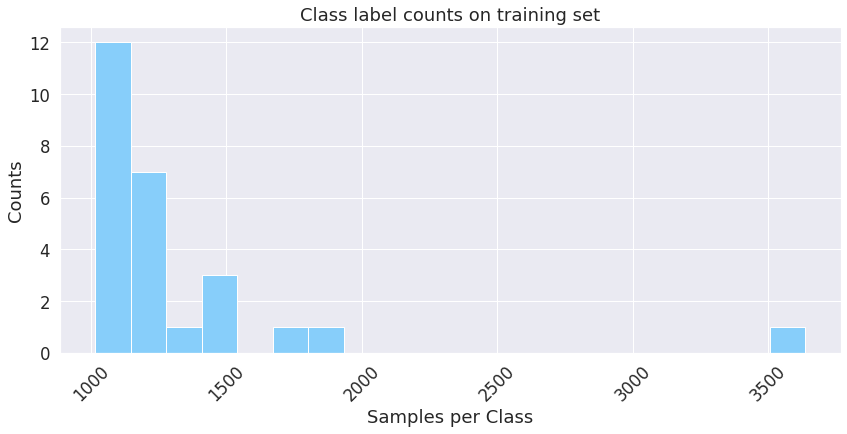

In [ ]:
histplot(train , "family_accession" , "Class label counts on training set")

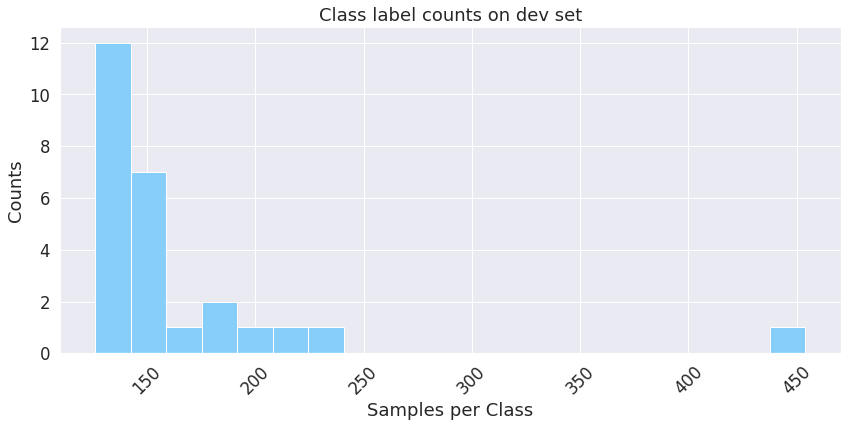

In [ ]:
histplot(dev , "family_accession" , "Class label counts on dev set")

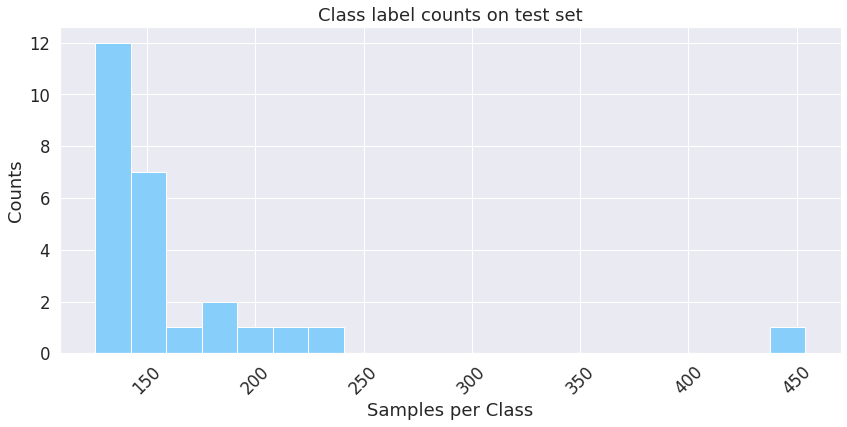

In [ ]:
histplot(test , "family_accession" , "Class label counts on test set")

The distribution of the classes labels is highly heterogeneous, with some classes overly represented in the dataset while other are barely represented on the training set. 

This must be taken into account when measuring the accuracy of the model, with the possibility to include a weighting factor as an evaluation metric.

In [ ]:
def plotChainLength(df , column , title):
    """
    -Description: Plot the distribution of length of the protein sequences

    @param DataFrame df: dataframe containing the class labels 
    @param str column: colun to access in the dataframe
    @param str title: title of the plot

    """
    lenSeq = df.apply(lambda row: len(row[column]), axis=1)
    sns.kdeplot(data = lenSeq, shade=True , color = "lightskyblue")
    plt.title("Sequence Length Density Distribution in " + title + " set")
    plt.xlabel("Sequence Length")
    plt.ylabel("Density")
    return 

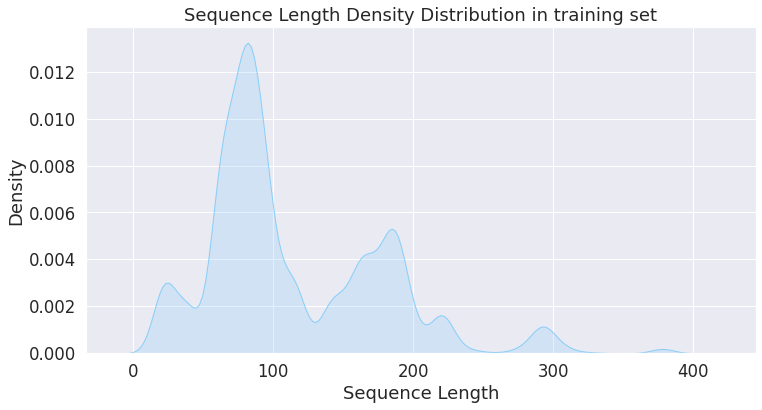

In [ ]:
plotChainLength(train , "sequence" , "training")

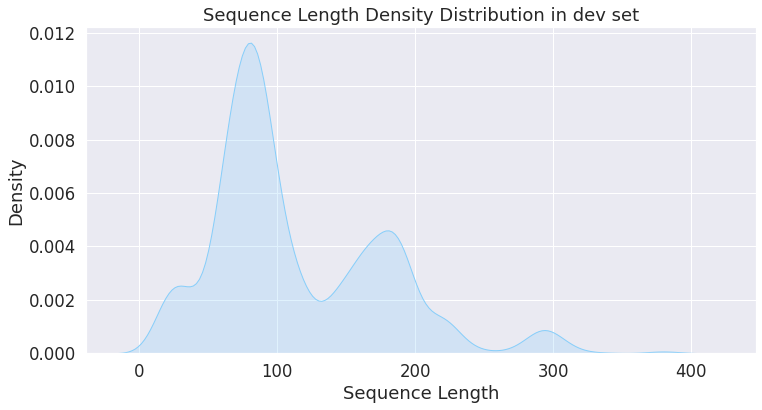

In [ ]:
plotChainLength(dev , "sequence" , "dev")

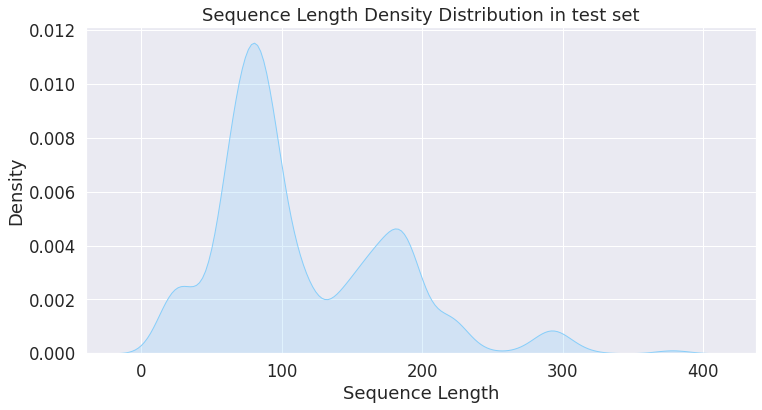

In [ ]:
plotChainLength(test , "sequence" , "test")

*   Since the problem will require to encode the sequences in some way, it is important to define a **maximum length** for the input. Based on the distribution of characters in all sets, it would be reasonable to have a maximum length set around 200 characters. 
After running into GPU RAM limitations, it was necessary to reduce the maximum length to 128.
*   Another design decision would be to discard long or extremely short sequences, but I will try to show how the proposed models are robust with respect to this type of data.



In [ ]:
MAX_LEN = 128

In [ ]:
from collections import Counter

def countAminoacids(df , seqCol):
    """
    -Description: Bar plot of occurences of aminoacids in the training set

    @param DataFrame df: dataframe containing the sequences
    @param str column: column to access in the dataframe

    """
    counter = Counter(aa for seq in df[seqCol].values.tolist() for aa in seq )
    y = [count for tag, count in counter.most_common()]
    x = [tag for tag, count in counter.most_common()]
    #Obtain values sorted for the bar plot
    sns.barplot(x=x,y=y, palette=("Blues_d"))
    plt.xlabel("Aminoacid counts")
    plt.ylabel("Aminoacid codes")
    plt.title("Aminoacid Counts in the training set")
    
    return 

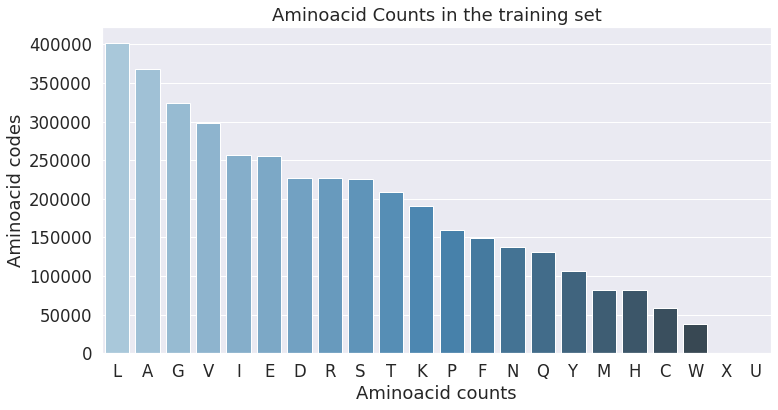

In [ ]:
countAminoacids(train , "sequence")

The occurences of some aminoacids are very limited. This is important to notice and usually in NLP applications the least occuring words are **mapped into a common token**. This is again a design question that I will consider. 



---



# Method Explanation:



*   Given the task of multi-class classification, it is necessary to find a model with the right **inductive bias** given the sequential nature of the input data. For this purpose, it is interesting to read recent papers on **NLP**, assuming that those methods that perform well for natural language would work in the case of protein sequences.
---
The first model that I will implement is based on the work of Jennifer M. Johnson *et al.* (2020) **Journal of Chemical Information and Modeling** : [Deep Dive into Machine Learning for Protein Engineering](https://pubs.acs.org/doi/10.1021/acs.jcim.0c00073).


*   The proposed model is a convolutional NN with dense layers on top, with the (1-dimensional) convolutional layers would be able to extract relevant features and learn the underlying patterns present in each protein family. Thus, these features extracted by the first layers would be relevant for the classification layers to perform the task.
*   Related to inductive biases, it is important to note how this architecture would be shift invariant (translational invariance), thanks to the max pooling layers as well.

![picture](https://drive.google.com/uc?export=view&id=1YCmmJ30kkwD8-h8erAadAK89uBlZVTst)


---


Given the success of pre-trained models in NLP, my second solution would be geared towards leveraging transfer learning. In particular, I will be using the model from Burkhard Rost *et al.* (2020) **IEEE Transactions on Pattern Analysis and Machine Intelligence** [ProtTrans: Towards Cracking the Language of Life’s Code Through Self-Supervised Learning](https://doi.org/10.1101/2020.07.12.199554). The model hosted on HuggingFace API [ProtBert](https://huggingface.co/Rostlab/prot_bert) was trained on a self-supervised task, namely MLM (Masked-Language Model). 



*   After downloading the model with the trained parameters, I will add additional layers for the classifier and then **fine-tune** the whole resulting model in our downstream task. 
*   Pre-training on a MLM objective also allows to learn an internal representation which can be used by the classification layers to incorporate useful features. Transformer-based models capitlize on the **attention mechanism**, such that a certain element of the sequence can attend on another element, thus in a sense it is able to generate contextual embeddings.


![picture](https://drive.google.com/uc?export=view&id=15jY6eLQJ_K3nwi_kb5_niNqLPdeXKugz)




---


It is also important to note how the paper which produced the dataset by *Bileschi et al.* (2019) **BioArxiv** [Can Deep Learning Classify the Protein Universe](https://research.google/pubs/pub48390/#:~:text=Our%20model%20co%2Dlocates%20sequences,purpose%20protein%20function%20prediction%20tools.) is based on a 1-D CNN model as well. 

# Experiment Description

*   The hypothesis that I want to test in this experiment is if fine-tuning a **pre-trained LM on the classification task performs better than convolutional based models**.
*   The evaluation metric for this experiment will be accuracy on the hold-out set, the test set. With more domain knowledge it could also be interesting to understand performance for a particularly important class, where more insightful metrics could be employed (Precision, recall and F1 for example). 



In [ ]:
#Slice the datasets such that only relevant columns remain
train = train[["sequence" , "family_accession"]]
dev = dev[["sequence" , "family_accession"]]
test = test[["sequence" , "family_accession"]]

For the CNN model, I will implement the model in Keras, thus it is necessary to convert the target labels into a onehot encoded representation.

In [ ]:
from sklearn.preprocessing import OneHotEncoder
import numpy as np
enc = OneHotEncoder(sparse=False, handle_unknown = 'ignore')
y_train = np.expand_dims(train["family_accession"].values, -1)
y_dev = np.expand_dims(dev["family_accession"].values, -1)
y_test = np.expand_dims(test["family_accession"].values, -1)

enc.fit(y_train)

y_train = enc.transform(y_train)
y_dev = enc.transform(y_dev)
y_test = enc.transform(y_test)

In [ ]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D,AveragePooling1D, Flatten ,Dropout,BatchNormalization
from keras.layers.embeddings import Embedding
from keras.callbacks import EarlyStopping

from keras.preprocessing import text, sequence
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split

In order to input the protein sequences, it is necesary to implement a tokenizer to map character occurences into numbers. Then, the sequences which contain less characters than the maximum length, need to be padded to ensure that every data point has the same dimensions.

In [ ]:
tokenizer = Tokenizer(char_level=True)
tokenizer.fit_on_texts(train["sequence"])
#represent input data as word rank number sequences
X_train = tokenizer.texts_to_sequences(train["sequence"])
X_train = sequence.pad_sequences(X_train, maxlen=MAX_LEN)

X_dev = tokenizer.texts_to_sequences(dev["sequence"])
X_dev = sequence.pad_sequences(X_dev, maxlen=MAX_LEN)

X_test = tokenizer.texts_to_sequences(test["sequence"])
X_test = sequence.pad_sequences(X_test, maxlen=MAX_LEN)

The first layer of the model is going to be an Embedding layer, which matches every character in our vocabulary into a dense vector. This mapping is also learned as the other parameters in the network, leading to a more appropiate representation where then the convolutional layers can operate. 
This leads to another design decision, which is the **dimensionality of the embeddings**.
In fact, this can be tuned by resorting to the validation set.

In [ ]:
from functools import partial
def cnnModel(output_shape , max_len , tokenizer , embedding_dim):
        '''
        @param int output_shape: output shape corresponding to the number of classes
        @param int max_len: maximum length for the sequences
        @param Tokenizer: keras tokenizer used as input for the embedding layer
        @param int embedding_dim: 

        @output keras.Sequential model: final model without compulation
        '''

        model = Sequential([ 
            Embedding(len(tokenizer.word_index)+1, embedding_dim, input_length=max_len),
            Conv1D(filters=4, kernel_size=5, padding='same', activation=partial(tf.nn.leaky_relu, alpha=0.02)),
            BatchNormalization(),   
            MaxPooling1D(pool_size=2, padding='valid'),
            Conv1D(filters=8, kernel_size=3, padding='same', activation=partial(tf.nn.leaky_relu, alpha=0.02)),
            BatchNormalization(), 
            MaxPooling1D(pool_size=2, padding='valid'),
            Flatten(),
            Dense(16, activation=partial(tf.nn.leaky_relu, alpha=0.02)),
            Dropout(.5),
            Dense(output_shape, activation='softmax')
        ])
        return model

In [ ]:
EMBED_DIM = 64

In [ ]:
cnn_model = cnnModel(NUM_CLASSES , MAX_LEN , tokenizer , EMBED_DIM)
cnn_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
ES = EarlyStopping(monitor='val_accuracy', verbose=1, patience=3)

In [ ]:
print(cnn_model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 128, 64)           1472      
                                                                 
 conv1d (Conv1D)             (None, 128, 4)            1284      
                                                                 
 batch_normalization (BatchN  (None, 128, 4)           16        
 ormalization)                                                   
                                                                 
 max_pooling1d (MaxPooling1D  (None, 64, 4)            0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 64, 8)             104       
                                                                 
 batch_normalization_1 (Batc  (None, 64, 8)            3

In [ ]:
history = cnn_model.fit(X_train, y_train,  batch_size=128, verbose=1, validation_data = (X_dev , y_dev),callbacks=[ES],epochs=50)

Epoch 1/50
269/269 [==============================] - 15s 15ms/step - loss: 2.3775 - accuracy: 0.3017 - val_loss: 2.5697 - val_accuracy: 0.2990
Epoch 2/50
269/269 [==============================] - 3s 12ms/step - loss: 1.3316 - accuracy: 0.5732 - val_loss: 0.5474 - val_accuracy: 0.9207
Epoch 3/50
269/269 [==============================] - 3s 12ms/step - loss: 1.0443 - accuracy: 0.6546 - val_loss: 0.2547 - val_accuracy: 0.9558
Epoch 4/50
269/269 [==============================] - 3s 12ms/step - loss: 0.9175 - accuracy: 0.6890 - val_loss: 0.2120 - val_accuracy: 0.9546
Epoch 5/50
269/269 [==============================] - 3s 12ms/step - loss: 0.8557 - accuracy: 0.7041 - val_loss: 0.1423 - val_accuracy: 0.9719
Epoch 6/50
269/269 [==============================] - 3s 12ms/step - loss: 0.8092 - accuracy: 0.7255 - val_loss: 0.1407 - val_accuracy: 0.9726
Epoch 7/50
269/269 [==============================] - 3s 12ms/step - loss: 0.7728 - accuracy: 0.7367 - val_loss: 0.1486 - val_accuracy: 0.967

**Early stopping** is applied based on the loss function evaluated on the validation set, preventing the model from overfitting to the training set. Other hyperparameters of the network can be tuned as well using the validation set.

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

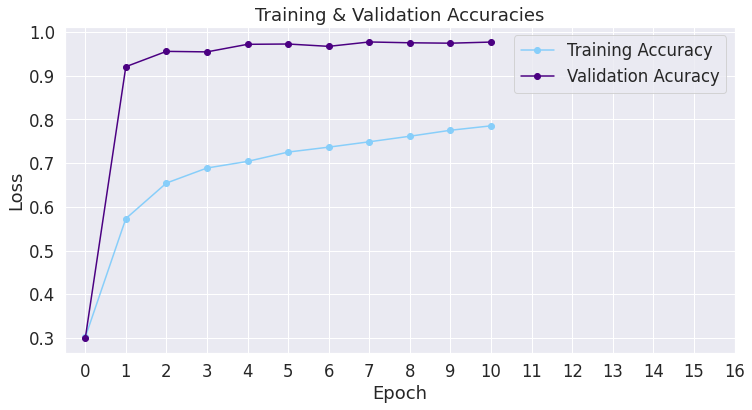

In [ ]:
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(history.history["accuracy"], '-o', label="Training Accuracy" , color = "lightskyblue")
plt.plot(history.history["val_accuracy"], '-o', label="Validation Acuracy" , color = "indigo")

# Label the plot.
plt.title("Training & Validation Accuracies")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks(list(range(17)))

plt.show()

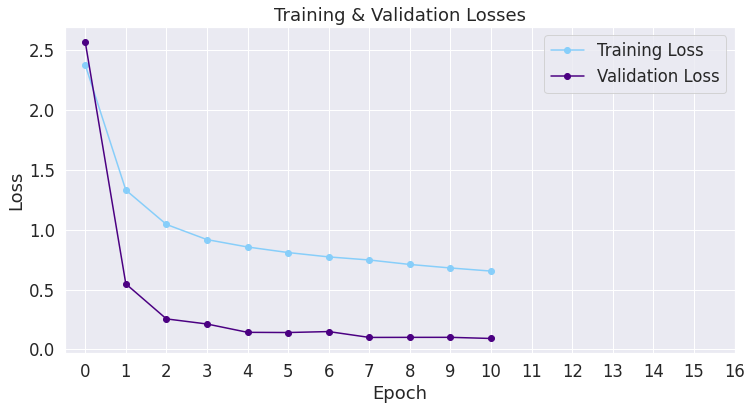

In [ ]:
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(history.history["loss"], '-o', label="Training Loss" , color = "lightskyblue")
plt.plot(history.history["val_loss"], '-o', label="Validation Loss" , color = "indigo")

# Label the plot.
plt.title("Training & Validation Losses")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks(list(range(17)))

plt.show()

In [ ]:
cnn_eval = cnn_model.evaluate(X_test, y_test)

print("Test Set Accuracy: {:.2f}".format(cnn_eval[1]*100))

134/134 [==============================] - 1s 8ms/step - loss: 0.1071 - accuracy: 0.9759
Test Set Accuracy: 97.59


For this second model, I will do the implementation in PyTorch, which would require a different encoding for the labels of the class. 

In [ ]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
label_encoder.fit(train["family_accession"].values)

train["family_accession"] = label_encoder.transform(train["family_accession"])
dev["family_accession"] = label_encoder.transform(dev["family_accession"])
test["family_accession"] = label_encoder.transform(test["family_accession"])

Considering the preprocessing described in [ProtBert](https://huggingface.co/Rostlab/prot_bert) , it is necessary that every character in the sequence is white-space separated, and the less common aminoacids UZOB should be mapped to X as input for the tokenizer.

In [ ]:
import re
train["sequence"] = train["sequence"].apply(lambda x : " ".join(x))
dev["sequence"] = dev["sequence"].apply(lambda x : " ".join(x))
test["sequence"] = test["sequence"].apply(lambda x : " ".join(x))
train["sequence"] = list(map(lambda seq : re.sub(r"[UZOB]", "X", seq ) , train["sequence"].values.tolist()))

dev["sequence"] = list(map(lambda seq : re.sub(r"[UZOB]", "X", seq ) , dev["sequence"].values.tolist()))

test["sequence"] = list(map(lambda seq : re.sub(r"[UZOB]", "X", seq ) , test["sequence"].values.tolist()))

In [ ]:
#Checking the result of the preprocessing stage
train.iloc[0].sequence

In [ ]:
!pip install transformers

In [ ]:
from transformers import BertModel, BertTokenizer
tokenizer = BertTokenizer.from_pretrained("Rostlab/prot_bert", do_lower_case=False )
pretrained_model = BertModel.from_pretrained("Rostlab/prot_bert")

Downloading:   0%|          | 0.00/86.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/81.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/361 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.57G [00:00<?, ?B/s]

Some weights of the model checkpoint at Rostlab/prot_bert were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
import torch
import numpy as np
from torch import nn
import torch.utils.data
import torch.utils.data.distributed
from torch.utils.data import Dataset, DataLoader, RandomSampler, TensorDataset

class proteinDataset(Dataset):
    def __init__(self, sequence, targets, tokenizer, max_len):
        '''
        @param list[str] sequence: protein sequence
        @param list[str] targets: list containing the labels
        @param custom tokenizer: huggingface tokenizer
        @param int max_len: maximum length to truncate the sequences 
        '''
        self.sequence = sequence
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len
    def __len__(self):
        return len(self.sequence)

    def __getitem__(self, item):
        sequence = str(self.sequence[item])
        target = self.targets[item]
        encoding = self.tokenizer.encode_plus(
            sequence,
            truncation=True,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
        )
        return {
          'protein_sequence': sequence,
          'input_ids': encoding['input_ids'].flatten(),
          'attention_mask': encoding['attention_mask'].flatten(),
          'target': torch.tensor(target, dtype=torch.long)
        }

In [ ]:
train_set = proteinDataset(train["sequence"].values.tolist() , train["family_accession"].values.tolist() , tokenizer , MAX_LEN)
dev_set = proteinDataset(dev["sequence"].values.tolist() , dev["family_accession"].values.tolist() , tokenizer , MAX_LEN)
test_set = proteinDataset(test["sequence"].values.tolist() , test["family_accession"].values.tolist() , tokenizer , MAX_LEN)

In [ ]:
class pfamClassifier(nn.Module):
    def __init__(self, n_classes , model):
        '''
        @param int n_classes: number of unique classes present in the dataset
        @param custom model: huggingface downloaded model
        '''
        super().__init__()
        self.model = model
        self.classifier = nn.Sequential(nn.Dropout(p=0.2),
                                        nn.Linear(self.model.config.hidden_size, n_classes),
                                        nn.Tanh())
        
    def forward(self, input_ids, attention_mask):
        '''
        @param Tensor input_ids: tokenized inputs for the pre-trained model
        @param Tensor attention_mask

        @out Tensor: output from the classifier
        '''
        output = self.model(
          input_ids=input_ids,
          attention_mask=attention_mask
        )
        return self.classifier(output.pooler_output)

In [ ]:
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('GPU:', torch.cuda.get_device_name(0))
else:
    device = 'cpu'
    print('No GPU available')

There are 1 GPU(s) available.
GPU: Tesla K80


In [ ]:
model = pfamClassifier(NUM_CLASSES ,  pretrained_model)
model.to(device)

pfamClassifier(
  (model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30, 1024, padding_idx=0)
      (position_embeddings): Embedding(40000, 1024)
      (token_type_embeddings): Embedding(2, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwi

In [ ]:
params = list(model.named_parameters())

print('The pretrained model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Pre-trained Layers ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The pretrained model has 489 different named parameters.

==== Embedding Layer ====

model.embeddings.word_embeddings.weight                   (30, 1024)
model.embeddings.position_embeddings.weight             (40000, 1024)
model.embeddings.token_type_embeddings.weight              (2, 1024)
model.embeddings.LayerNorm.weight                            (1024,)
model.embeddings.LayerNorm.bias                              (1024,)

==== Pre-trained Layers ====

model.encoder.layer.0.attention.self.query.weight       (1024, 1024)
model.encoder.layer.0.attention.self.query.bias              (1024,)
model.encoder.layer.0.attention.self.key.weight         (1024, 1024)
model.encoder.layer.0.attention.self.key.bias                (1024,)
model.encoder.layer.0.attention.self.value.weight       (1024, 1024)
model.encoder.layer.0.attention.self.value.bias              (1024,)
model.encoder.layer.0.attention.output.dense.weight     (1024, 1024)
model.encoder.layer.0.attention.output.dense.bias      




---


*   Epochs: when finetuning a LM, only a few epochs suffice to achieve great performances on a dowstream task. In this case, I will use only 1 due to computational power constraints.
*   Learning rate and batch size are crucial hyperparameters when fine-tuning. A large learning rate would cause **catastrophic forgetting** of the weights learned during MLM objective. There are some guidelines on the [Bert Repository](https://github.com/google-research/bert).




---






In [ ]:
EPOCHS = 1
BATCH_SIZE = 8
LEARNING_RATE = 1e-5
output_path = "."
EVAL_BATCH = 1072
#Set a checkpoint to evaluate the model after training on EVAL_BATCH number of batches

In [ ]:
train_loader  = DataLoader(dataset = train_set , batch_size = BATCH_SIZE ,drop_last=True)
dev_loader = DataLoader(dataset = dev_set , batch_size = BATCH_SIZE  ,drop_last=True)
test_loader = DataLoader(dataset = test_set , batch_size = BATCH_SIZE ,drop_last=True)

In [ ]:
len(train_loader)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [ ]:
from tqdm import tqdm

In [ ]:
def multi_acc(y_pred, y_test):
    '''
    @param Tensor y_pred: tensor containig the actual labels 
    @param Tensor y_test: output from the model, it is still necessary to convert those into a probability via softmax.

    @output Float acc: accuracy on the batch
    '''
    
    y_pred_softmax = torch.log_softmax(y_pred, dim = 1)
    _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)    
    correct_pred = (y_pred_tags == y_test).int()
    acc = correct_pred.sum()*1.0 / len(correct_pred)*100
    return acc

In [ ]:
losses = {
    'train' : [],
    'val' : [] 
}

accuracies = {
    'train' : [],
    'val' : [] 
}

In [ ]:
import shutil

def save_checkpoint(path , state, filename):
    torch.save(state, filename)
    #shutil.copyfile(path, filename)

In [ ]:
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU


In [ ]:
GPUs = GPU.getGPUs()
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), 
       " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB"
        .format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

Gen RAM Free: 8.6 GB  | Proc size: 6.8 GB
GPU RAM Free: 9317MB | Used: 2124MB | Util  19% | Total 11441MB


In [ ]:
# Initialize losses and loss histories
train_loss = 0.0
val_loss = 0.0
best_valid_loss = float('Inf')
train_acc = 0.0
val_acc = 0.0
step = 0

model.train()

# Train loop
for epoch in range(EPOCHS):
    for j,train_batch in enumerate(tqdm(train_loader)):
        train_mask = train_batch['attention_mask'].to(device)
        train_input = train_batch['input_ids'].to(device)
        train_targets = train_batch['target'].to(device)

        train_y_pred = model(input_ids=train_input,  
                        attention_mask=train_mask)
        loss = criterion(train_y_pred, train_targets)
        
        loss.backward()

        optimizer.step()    
            
        optimizer.zero_grad()
        
        # Update train loss and global step
        train_loss += loss.item()
        train_acc += multi_acc(train_y_pred , train_targets)
        step += 1

        # Validation loop. Save progress and evaluate model performance.

        if (step % EVAL_BATCH) == 0:       
          with torch.no_grad():     
              model.eval()               
              for i,val_batch in enumerate(dev_loader):
                  val_mask = val_batch['attention_mask'].to(device)
                  val_input = val_batch['input_ids'].to(device)
                  val_targets = val_batch['target'].to(device)


                  val_y_pred = model(input_ids=val_input,  
                                attention_mask=val_mask)

                  
                  loss = criterion(val_y_pred, val_targets)
                  
                  val_loss += loss.item()
                  val_acc += multi_acc(val_y_pred , val_targets)
              # Store train and validation loss history
              train_loss /= step
              val_loss /=  len(dev_loader)  
              train_acc /= step
              val_acc /= len(dev_loader)
              losses['train'].append(train_loss)
              losses['val'].append(val_loss)
              accuracies['train'].append(train_acc)
              accuracies['val'].append(val_acc)

              print('BATCH [{}/{}]  | Train Loss: {:.4f}, Valid Loss: {:.4f} , Train Acc: {:4f}, Val Acc: {:4f}'
                    .format(j + 1, len(train_loader),
                            train_loss, val_loss , train_acc , val_acc))
              
              # checkpoint
              
              if best_valid_loss > val_loss:
                  best_valid_loss = val_loss
                  save_checkpoint("/" +output_path ,
                      {
                    'epoch': epoch + 1,
                    'state_dict': model.state_dict(),
                    'best_prec1': val_acc,
                    'optimizer' : optimizer.state_dict(),
                    }, 'finetuned_model.pt')

              train_loss = 0.0                
              val_loss = 0.0
              step = 0
              model.train()

print('Training done!')

 25%|██▍       | 1071/4292 [29:40<1:28:37,  1.65s/it]

BATCH [1072/4292]  | Train Loss: 2.3809, Valid Loss: 1.8529 , Train Acc: 75.664642, Val Acc: 99.602058


 50%|████▉     | 2143/4292 [1:05:00<59:56,  1.67s/it]

BATCH [2144/4292]  | Train Loss: 1.6851, Valid Loss: 1.5819 , Train Acc: 99.137741, Val Acc: 99.882217


 75%|███████▍  | 3215/4292 [1:40:12<30:01,  1.67s/it]

BATCH [3216/4292]  | Train Loss: 1.5492, Valid Loss: 1.5199 , Train Acc: 99.637726, Val Acc: 99.952965


100%|█████████▉| 4287/4292 [2:15:26<00:08,  1.67s/it]

BATCH [4288/4292]  | Train Loss: 1.5094, Valid Loss: 1.4975 , Train Acc: 99.813095, Val Acc: 100.046730


100%|██████████| 4292/4292 [2:20:55<00:00,  1.97s/it]

Training done!


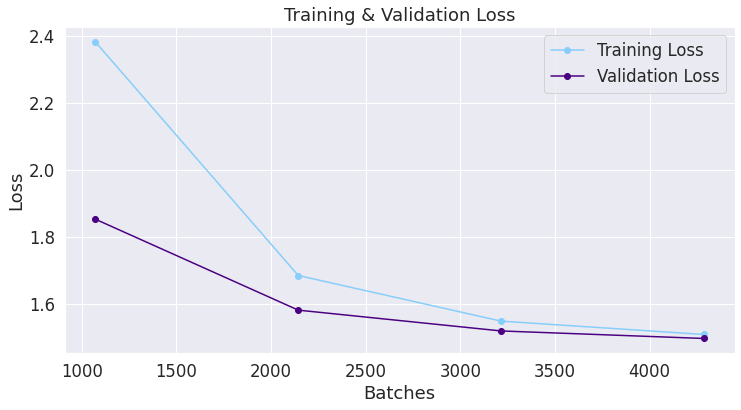

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("darkgrid")
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(np.array([1, 2, 3, 4])*EVAL_BATCH , losses["train"], '-o', label="Training Loss" , color = "lightskyblue")
plt.plot(np.array([1, 2, 3, 4])*EVAL_BATCH , losses["val"], '-o', label="Validation Loss" , color = "indigo")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Batches")
plt.ylabel("Loss")
plt.legend()

plt.show()

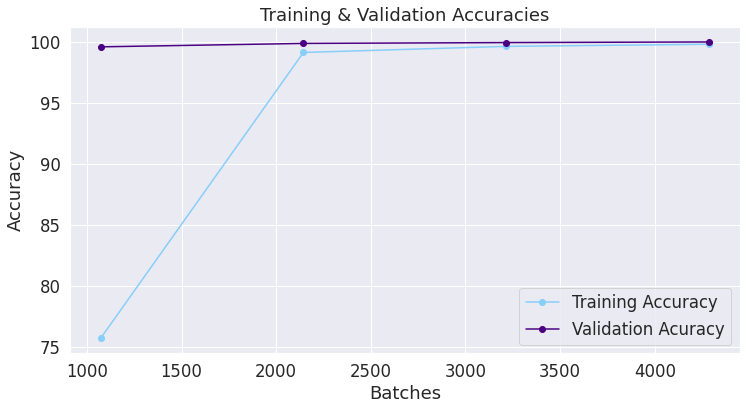

In [ ]:
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(np.array([1, 2, 3, 4])*EVAL_BATCH , accuracies["train"], '-o', label="Training Accuracy" , color = "lightskyblue")
plt.plot(np.array([1, 2, 3, 4])*EVAL_BATCH , accuracies["val"], '-o', label="Validation Acuracy" , color = "indigo")

# Label the plot.
plt.title("Training & Validation Accuracies")
plt.xlabel("Batches")
plt.ylabel("Accuracy")
plt.legend()


plt.show()

In [ ]:
test_loss = 0.0
test_acc = 0.0
with torch.no_grad():   
    print(' Starting Evaluation on Test Set ')  
    model.eval()               
    for i,test_batch in enumerate(tqdm(test_loader)):
        test_mask = test_batch['attention_mask'].to(device)
        test_input = test_batch['input_ids'].to(device)
        test_targets = test_batch['target'].to(device)


        test_y_pred = model(input_ids=test_input,  
                      attention_mask=test_mask)

        
        loss = criterion(test_y_pred, test_targets)
        
        test_loss += loss.item()
        test_acc += multi_acc(test_y_pred , test_targets)
        torch.cuda.empty_cache()
    # Store train and validation loss history
    test_loss /= len(test_loader)  
    test_acc /= len(test_loader)
    
print('Test Loss: {:.4f} , Test Accuracy: {:4f}'
    .format(test_loss , test_acc))

 Starting Evaluation on Test Set 


100%|██████████| 534/534 [05:09<00:00,  1.72it/s]

Test Loss: 1.4969 , Test Accuracy: 99.882957


# Results Analysis



*   CNN-based model is able to achieve 97% accuracy on the held-out set, thus proving that a convolutional model is able to capture the dependencies and underlying patterns in the protein sequence. Using an embedding layer and batch normalization provide the right inductive bias for learning representations of the protein sequences. Also, running the model on a GPU allows for an extremely fast learning with the subset of the data that I was using.
*   The fine-tuned transformer model is able to achieve 99% accuracy on the test set, showcasing the power of transfer learning for downstream tasks. The main drawback would be both training time and inference time, which would require a lot more computational power. This implementation allows further interpretability of the model by visualizing attention weights in the transformer architecture.


*   It is also remarkable how both models are robust with respect to short sequences and truncation set up to only 128 characters as well. 







---


Further work:



*   Test the same models trained on the whole dataset, given access to more computational power.
*   Another interesting point would be related to few-shot learning. Siamese networks have shown to perform well without many labelled examples. More precisely, it would be interesting to leverage the same transformer architecture to obtain the learned representation and compute similarity metrics among samples to perform the classification. This type of siamese transformer architectures have been shown to perform well in NLP in the work by Shuai Gao *et al.* (2021) [TBSN: Sparse-Transformer Based Siamese Network for Few-Shot Action Recognition](https://ieeexplore.ieee.org/document/9441568).

